# Test & Evaluation the model

In [1]:
import os
import datetime
os.environ['CUDA_VISIBLE_DEVICES'] = "1"     #use GPU-0 

from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import cv2
import os
import random
import time
import shutil
from sklearn.utils import shuffle
%matplotlib inline

patch_size=48        
dataset_path='F:/cvpr/project/ijaz/dataset/'   
checkpoint_path=dataset_path+"ckpt/"

test_dir=dataset_path+"test/"
test_image_dir=test_dir+"images/"
test_mask_dir=test_dir+"mask/"
test_groundtruth_dir=test_dir+"groundtruth/"
test_save_dir=test_dir+"pred_result/"
test_image_path_list=glob(test_image_dir+"*.tif")

print("number of testing images:",len(test_image_path_list))

number of testing images: 0


## Model Defination

**Please keep it same as the training notebook**

In [3]:
import tensorflow as tf

gpus=tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
from tensorflow.keras import backend as K
from tensorflow.keras.layers import AveragePooling2D,Conv2DTranspose,Input,Add,Conv2D, BatchNormalization,LeakyReLU, Activation, MaxPool2D, Dropout, Flatten, Dense,UpSampling2D,Concatenate,Softmax

# define the model under eager mode

class LinearTransform(tf.keras.Model):
  def __init__(self, name="LinearTransform"):
    super(LinearTransform, self).__init__(self,name=name)

    self.conv_r=Conv2D(1,kernel_size=3,strides=1,padding='same',use_bias=False)
    self.conv_g=Conv2D(1,kernel_size=3,strides=1,padding='same',use_bias=False)
    self.conv_b=Conv2D(1,kernel_size=3,strides=1,padding='same',use_bias=False)

    self.pool_rc=AveragePooling2D(pool_size=(patch_size,patch_size),strides=1)
    self.pool_gc=AveragePooling2D(pool_size=(patch_size,patch_size),strides=1)
    self.pool_bc=AveragePooling2D(pool_size=(patch_size,patch_size),strides=1)
        
    self.bn=BatchNormalization()
    self.sigmoid=Activation('sigmoid')
    self.softmax=Activation('softmax')

  def call(self, input,training=True):
    r,g,b=input[:,:,:,0:1],input[:,:,:,1:2],input[:,:,:,2:3]

    rs=self.conv_r(r)
    gs=self.conv_g(g)
    bs=self.conv_r(b)

    rc=tf.reshape(self.pool_rc(rs),[-1,1])
    gc=tf.reshape(self.pool_gc(gs),[-1,1])
    bc=tf.reshape(self.pool_bc(bs),[-1,1])

    merge=Concatenate(axis=-1)([rc,gc,bc])
    merge=tf.expand_dims(merge,axis=1)
    merge=tf.expand_dims(merge,axis=1)
    merge=self.softmax(merge)
    merge=tf.repeat(merge,repeats=48,axis=2)
    merge=tf.repeat(merge,repeats=48,axis=1)

    r=r*(1+self.sigmoid(rs))
    g=g*(1+self.sigmoid(gs))
    b=b*(1+self.sigmoid(bs))

    output=self.bn(merge[:,:,:,0:1]*r+merge[:,:,:,1:2]*g+merge[:,:,:,2:3]*b,training=training)
    return output

class ResBlock(tf.keras.Model):
  def __init__(self,out_ch,residual_path=False,stride=1):
    super(ResBlock,self).__init__(self)
    self.residual_path=residual_path
        
    self.conv1=Conv2D(out_ch,kernel_size=3,strides=stride,padding='same', use_bias=False,data_format="channels_last")
    self.bn1=BatchNormalization()
    self.relu1=LeakyReLU()#Activation('leaky_relu')
        
    self.conv2=Conv2D(out_ch,kernel_size=3,strides=1,padding='same', use_bias=False,data_format="channels_last")
    self.bn2=BatchNormalization()
        
    if residual_path:
      self.conv_shortcut=Conv2D(out_ch,kernel_size=1,strides=stride,padding='same',use_bias=False)
      self.bn_shortcut=BatchNormalization()
        
    self.relu2=LeakyReLU()#Activation('leaky_relu')
        
  def call(self,x,training=True):
    xs=self.relu1(self.bn1(self.conv1(x),training=training))
    xs=self.bn2(self.conv2(xs),training=training)

    if self.residual_path:
      x=self.bn_shortcut(self.conv_shortcut(x),training=training)
    #print(x.shape,xs.shape)
    xs=x+xs
    return self.relu2(xs)


class Unet(tf.keras.Model):
  def __init__(self):
    super(Unet,self).__init__(self)
    self.conv_init=LinearTransform()
    self.resinit=ResBlock(16,residual_path=True)
    self.up_sample=UpSampling2D(size=(2,2),interpolation='bilinear')
    self.resup=ResBlock(32,residual_path=True)
    
    self.pool1=MaxPool2D(pool_size=(2,2))

    self.resblock_down1=ResBlock(64,residual_path=True)
    self.resblock_down11=ResBlock(64,residual_path=False)
    self.pool2=MaxPool2D(pool_size=(2,2))

    self.resblock_down2=ResBlock(128,residual_path=True)
    self.resblock_down21=ResBlock(128,residual_path=False)
    self.pool3=MaxPool2D(pool_size=(2,2))

    self.resblock_down3=ResBlock(256,residual_path=True)
    self.resblock_down31=ResBlock(256,residual_path=False)
    self.pool4=MaxPool2D(pool_size=(2,2))

    self.resblock=ResBlock(512,residual_path=True)

    self.unpool3=UpSampling2D(size=(2,2),interpolation='bilinear')
    self.resblock_up3=ResBlock(256,residual_path=True)
    self.resblock_up31=ResBlock(256,residual_path=False)

    self.unpool2=UpSampling2D(size=(2,2),interpolation='bilinear')
    self.resblock_up2=ResBlock(128,residual_path=True)
    self.resblock_up21=ResBlock(128,residual_path=False)

    self.unpool1=UpSampling2D(size=(2,2),interpolation='bilinear')
    self.resblock_up1=ResBlock(64,residual_path=True)
    
    self.unpool_final=UpSampling2D(size=(2,2),interpolation='bilinear')
    self.resblock2=ResBlock(32,residual_path=True)
    
    self.pool_final=MaxPool2D(pool_size=(2,2))
    self.resfinal=ResBlock(32)
    
    self.conv_final=Conv2D(1,kernel_size=1,strides=1,padding='same',use_bias=False)
    self.bn_final=BatchNormalization()
    self.act=Activation('sigmoid')

  def call(self,x,training=True):
    x_linear=self.conv_init(x,training=training)
    x=self.resinit(x_linear,training=training)
    x=self.up_sample(x)
    x=self.resup(x,training=training)
    
    stage1=self.pool1(x)
    stage1=self.resblock_down1(stage1,training=training)
    stage1=self.resblock_down11(stage1,training=training)

    stage2=self.pool2(stage1)
    stage2=self.resblock_down2(stage2,training=training)
    stage2=self.resblock_down21(stage2,training=training)

    stage3=self.pool3(stage2)
    stage3=self.resblock_down3(stage3,training=training)
    stage3=self.resblock_down31(stage3,training=training)

    stage4=self.pool4(stage3)
    stage4=self.resblock(stage4,training=training)

    stage3=Concatenate(axis=3)([stage3,self.unpool3(stage4)])
    stage3=self.resblock_up3(stage3,training=training)
    stage3=self.resblock_up31(stage3,training=training)

    stage2=Concatenate(axis=3)([stage2,self.unpool2(stage3)])
    stage2=self.resblock_up2(stage2,training=training)
    stage2=self.resblock_up21(stage2,training=training)

    stage1=Concatenate(axis=3)([stage1,self.unpool1(stage2)])
    stage1=self.resblock_up1(stage1,training=training)
    
    x=Concatenate(axis=3)([x,self.unpool_final(stage1)])
    x=self.resblock2(x,training=training)
    
    x=self.pool_final(x)
    x=self.resfinal(x,training=training)
    
    seg_result=self.act(self.bn_final(self.conv_final(x),training=training))
    
    return x_linear,seg_result

## A. Test Model

### Image Preprocess

**Please keep it same as the training notebook**

In [4]:
def restrict_normalized(imgs,mask):
    imgs_normalized = np.empty(imgs.shape)
    imgs_std = np.std(imgs)
    imgs_mean = np.mean(imgs)
    imgs_normalized = (imgs-imgs_mean)/imgs_std
    for i in range(imgs.shape[2]):
        imgs_normalized[:,:,i] = ((imgs_normalized[:,:,i] - np.min(imgs_normalized[:,:,i])) / (np.max(imgs_normalized[:,:,i])-np.min(imgs_normalized[:,:,i])))*255
    return imgs_normalized

# CLAHE (Contrast Limited Adaptive Histogram Equalization)
#adaptive histogram equalization is used. In this, image is divided into small blocks called "tiles" (tileSize is 8x8 by default in OpenCV). Then each of these blocks are histogram equalized as usual. So in a small area, histogram would confine to a small region (unless there is noise). If noise is there, it will be amplified. To avoid this, contrast limiting is applied. If any histogram bin is above the specified contrast limit (by default 40 in OpenCV), those pixels are clipped and distributed uniformly to other bins before applying histogram equalization. After equalization, to remove artifacts in tile borders, bilinear interpolation is applied
def clahe_equalized(imgs):
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  imgs_equalized = np.empty(imgs.shape)
  for i in range(imgs.shape[2]):
    imgs_equalized[:,:,i] = clahe.apply(np.array(imgs[:,:,i], dtype = np.uint8))
  return imgs_equalized

def normalized(imgs):
  imgs_normalized =np.empty(imgs.shape)
  for i in range(imgs.shape[2]):
    imgs_normalized[:,:,i] =cv2.equalizeHist(imgs[:,:,i])
  return imgs_normalized

def adjust_gamma(imgs, gamma=1.0):
  invGamma = 1.0 / gamma
  table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
  # apply gamma correction using the lookup table
  new_imgs = np.empty(imgs.shape)
  for i in range(imgs.shape[2]):
    new_imgs[:,:,i] = cv2.LUT(np.array(imgs[:,:,i], dtype = np.uint8), table)
  return new_imgs

def preprocess(image,mask):
  
  assert np.max(mask)==1
  image=np.array(image)
  image[:,:,0]=image[:,:,0]*mask
  image[:,:,1]=image[:,:,1]*mask
  image[:,:,2]=image[:,:,2]*mask
  
  image=restrict_normalized(image,mask)
  image=clahe_equalized(image)
  image=adjust_gamma(image,1.2)
  image=image/255.0
  return image

### Image2Patch and Patch2Image

In [5]:
# pad images 
def padding_images(image,mask,stride):
    h,w=image.shape[:2]
    new_h,new_w=h,w
    while (new_h-patch_size)%stride!=0:
        new_h+=1
    while (new_w-patch_size)%stride!=0:
        new_w+=1
    pad_image=np.zeros((new_h,new_w,3))
    pad_image[:h,:w,:]=image
    
    pad_mask=np.zeros((new_h,new_w))
    pad_mask[:h,:w]=mask
    
    return pad_image,pad_mask

# images to patches 
def img2patch_list(image,stride=patch_size):
    patch_list=[]
    #image_binary=0.8*image[:,:,1:2]+0.2*image[:,:,2:3]  
    for j in range(0,image.shape[1]-patch_size+1,stride):
        for i in range(0,image.shape[0]-patch_size+1,stride):
            patch=image[i:i+patch_size,j:j+patch_size,:]
            patch_list.append(patch)
    return patch_list

# patches to image 
def patchlist2image(patch_list,stride,image_shape):
    result=np.zeros(image_shape[:2])
    sum_matrix=np.zeros(image_shape[:2])
    index_x,index_y=0,0
    for i in range(patch_list.shape[0]):
        patch=patch_list[i,:,:,0]
        #patch=np.where(patch>0.5,1,0)
        #print(patch)
        result[index_x:index_x+patch_size,index_y:index_y+patch_size]+=patch
        sum_matrix[index_x:index_x+patch_size,index_y:index_y+patch_size]+=1
        index_x+=stride
        if index_x+patch_size>image_shape[0]:
            index_x=0
            index_y+=stride
    return result/sum_matrix

### Test Main Function

In [6]:
testmodel=Unet()
ckpts = tf.train.Checkpoint(model=testmodel)
ckpts.restore(tf.train.latest_checkpoint(checkpoint_path)).expect_partial()

stride=5

def load_test_data(image):
  #image=tf.image.decode_jpeg(image,channels=1)
  #print(image.shape)
  image=tf.image.resize(image,[patch_size,patch_size])
  #image/=255.0
  return image

for i in range(len(test_image_path_list)):
  image_path=test_image_path_list[i]
  image_name=image_path.split("\\")[-1].split("_")[0]
  
  # load and process test images 
  image=plt.imread(image_path)
  original_shape=image.shape
  mask=plt.imread(test_mask_dir+image_name+"_test_mask.gif")
  mask=np.where(mask>0,1,0)
    
  # image to patches 
  image,pad_mask=padding_images(image,mask,stride)
  image=preprocess(image,pad_mask)
  test_patch_list=img2patch_list(image,stride)

  # test dataloader 
  test_dataset=tf.data.Dataset.from_tensor_slices(test_patch_list)
  test_dataset=test_dataset.map(load_test_data)
  test_dataset=test_dataset.batch(64)
  pred_result=[]
  
  # test process 
  print("testing image:",int(image_name))
  for batch, patch in enumerate(test_dataset):
    _,pred=testmodel(patch,training=False)
    
    pred=pred.numpy()
    pred_result.append(pred)
  pred_result=np.concatenate(pred_result,axis=0)
  
  # patches to image 
  print("post processing:",image_name)
  pred_image=patchlist2image(pred_result,stride,image.shape)
  
  pred_image=pred_image[:original_shape[0],:original_shape[1]]

  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
  print(mask.shape)
  mask = cv2.erode(mask.astype(np.uint8), kernel)

  pred_image=pred_image*mask
  pred_image=np.where(pred_image>0.5,1,0)
    
  # visualize the test result 
  plt.figure(figsize=(8,8))
  plt.title(image_name+"-("+str(image.shape[0])+","+str(image.shape[1])+")")
  plt.imshow(pred_image,cmap=plt.cm.gray)
  plt.show()

  plt.imsave(test_save_dir + str(int(image_name)) +".png",pred_image,cmap = plt.cm.gray)

## B. Evaluate Model

### Part-1

- sensitivity and specificity
- AUC and PR
- dice score

In [7]:
def dice(y_true,y_pred,smooth=1.):
  y_true=tf.cast(y_true,dtype=tf.float32)
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [8]:
test_groundtruth_path_list=sorted(glob(test_groundtruth_dir+"*.gif"))
test_pred_path_list=sorted(glob(test_save_dir+"*.png"))

dice_list=[]
roc_list=[]
pr_list=[]
tpr_list=[]
tnr_list=[]
sum_tp=0
sum_tn=0
sum_fp=0
sum_fn=0

roc = tf.keras.metrics.AUC(num_thresholds=200,curve="ROC")
pr = tf.keras.metrics.AUC(num_thresholds=200,curve="PR")
recall=tf.keras.metrics.Recall()


tn=tf.keras.metrics.TrueNegatives()
tp=tf.keras.metrics.TruePositives()
fn=tf.keras.metrics.FalseNegatives()
fp=tf.keras.metrics.FalsePositives()


for idx in range(len(test_groundtruth_path_list)):
    name=test_groundtruth_path_list[idx].split("\\")[-1].split(".")[0].split("_")[0]
    roc.reset_states()
    pr.reset_states()
    tn.reset_states()
    fn.reset_states()
    tp.reset_states()
    fp.reset_states()
    
    groundtruth=plt.imread(test_groundtruth_path_list[idx])
    preds=plt.imread(test_save_dir+str(int(name))+".png")
    preds = preds[:,:,0]
    groundtruth=np.array(groundtruth,dtype=np.float32)
    groundtruth=groundtruth/255.0
    
    roc.update_state(groundtruth,preds)   #png image is 4-channel
    pr.update_state(groundtruth,preds)
    tn.update_state(groundtruth,preds)
    tp.update_state(groundtruth,preds)
    fn.update_state(groundtruth,preds)
    fp.update_state(groundtruth,preds)
    
    dice_list.append(dice(groundtruth,preds).numpy())
    roc_list.append(roc.result().numpy())
    pr_list.append(pr.result().numpy())
    
    current_tn=tn.result().numpy()
    current_tp=tp.result().numpy()
    current_fn=fn.result().numpy()
    current_fp=fp.result().numpy()
    
    sum_tp+=current_tp
    sum_tn+=current_tn
    sum_fp+=current_fp
    sum_fn+=current_fn
    
    tpr_list.append(current_tp/(current_tp+current_fn))
    tnr_list.append(current_tn/(current_tn+current_fp))
    
print("average dice score for all predict vessel masks:",np.mean(dice_list))
print("average AUC for all predict vessel masks:",np.mean(roc_list))
print("average PR for all predict vessel masks:",np.mean(pr_list))
print("average recall(sensitivity) for all predict vessel masks:",np.mean(tpr_list))
print("average specificity for all predict vessel masks:",np.mean(tnr_list))

average dice score for all predict vessel masks: nan
average AUC for all predict vessel masks: nan
average PR for all predict vessel masks: nan
average recall(sensitivity) for all predict vessel masks: nan
average specificity for all predict vessel masks: nan


C:\Users\USER\anaconda3\envs\cvpr\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\USER\anaconda3\envs\cvpr\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Part-2

- Confusion Matrix

confusion [[0, 0], [0, 0]]


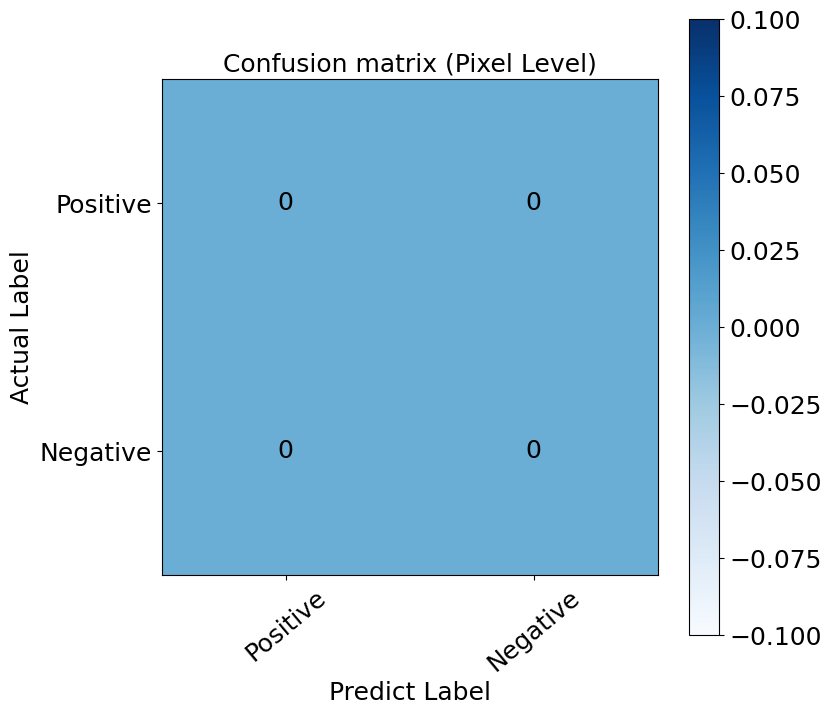

In [9]:
predict = ["Positive","Negative"]
actual = [ "Positive","Negative"]
classes = list(set(actual))
classes.sort(reverse=True)
confusion_matrix=[[sum_tp,sum_fn],[sum_fp,sum_tn]]
print("confusion",confusion_matrix)



plt.figure(figsize=(8,8))    
font_size=18
plt.imshow(confusion_matrix, cmap=plt.cm.Blues)
indices = range(len(confusion_matrix))
plt.xticks(indices, classes,rotation=40,fontsize=font_size)
plt.yticks([0.00,1.00], classes,fontsize=font_size)
plt.ylim(1.5 , -0.5)   

plt.title("Confusion matrix (Pixel Level)",fontdict={'weight':'normal','size': font_size})
plt.xlabel('Predict Label',fontsize=font_size)
plt.ylabel('Actual Label',fontsize=font_size)

for first_index in range(len(confusion_matrix)):
    for second_index in range(len(confusion_matrix[first_index])):
        if confusion_matrix[first_index][second_index]>1e6:
            text_color="w"
        else:
            text_color="black"
        plt.text(first_index, second_index, confusion_matrix[first_index][second_index],fontsize=font_size, color = text_color,verticalalignment='center',horizontalalignment='center',)

cb=plt.colorbar()
cb.ax.tick_params(labelsize=font_size)
plt.show()